<a href="https://colab.research.google.com/github/IrinaFab/CIFAR-10/blob/main/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CIFAR-10 CNN

* The Canadian Institute for Advanced Research (CIFAR-10) database is used as a multi-classification problem with ten classes as the output. 
* The dataset consists of 60,000 images already divided into 50,000 labeled images for the training dataset and 10,000 labeled images for the testing dataset. 
* 5000 images from the training dataset are set apart and used to validate the model's accuracy *during* training. 
* The 10 different classes: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There is no difference in the distribution of labels within the two datasets.
* The images are color and of size 32x32x3 (wxhxd, three channels R,G,B) pixels. 
* A convolutional neural network model was trained to classify these images.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

### Mount Google Drive to Colab Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing packages 

In [2]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verifying TensorFlow Version and Keras Version

In [3]:
print('This notebook requires TensorFlow 2.0 or above')
print('TensorFlow version: ', tf.__version__)
assert version.parse(tf.__version__).release[0] >=2
print('Keras version: ', keras.__version__)

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0
Keras version:  2.8.0


### Functions for Research Assignment

In [4]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [5]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    plt.ylabel('true label')
    plt.xlabel('predicted label')

### Loading CIFAR-10 Dataset




In [6]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 6s 0us/step


* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes 32x32
* y_train, y_test: uint8 arrays of digit labels, integers from 0-9

### EDA Training and Test Datasets


In [7]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t{}'.format(x_test.shape))
print('test_labels:\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:	(10000, 32, 32, 3)
test_labels:	(10000, 1)


### Review labels for training dataset

In [8]:
print('The first ten labels training dataset:\n {}\n'.format(y_train[0:10]))
print('These are the numeric labels which will be converted to items description.')

The first ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

These are the numeric labels which will be converted to items description.


### Plot Examples

In [9]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [10]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [11]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

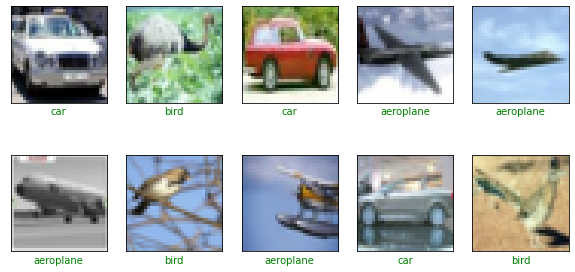

In [12]:
class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)

### Preprocessing data for model development

The labels are an array of integers, ranging from 0 to 9, and corresponding correspond to the classes:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [13]:
class_names = ['airplane',
               'automobile',
               'bird',
               'cat',
               'deer',
               'dog',
               'frog',
               'horse',
               'ship',
               'truck']

### Creating validation dataset


In [14]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train,
                                                                              y_train,
                                                                              test_size=.1,
                                                                              random_state=42,
                                                                              shuffle=True)

### Confirming Datasets {Train, Validation, Test}

In [15]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


### Scaling  {Train, Validation, Test}
* The images are 32x32x3 NumPy arrays, with pixel value between 0 and 255, 0 = turned off and 255 = maximum brightness.
* Although not absolutely necessary, scaling helps with the convergence of gradient descent.
* Scale to values between 0 and 1.
 

In [16]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

### Building CNN Model

* The training dataset is used for training the model, the test dataset is used for evaluating the model, and the validation set is used for tuning the model.
* Input the images
* Sequential class defined in Keras to create our model. 
1. Feature learning:
* Conv2D layer + ReLu layer:
  - Filters (kernels): How many features do you want to extract from the image in this layer? 
 - Kernel_size: 3x3 convolutional window shifting from left to right over the pixels
  - Strides: shifts over by 1
* MaxPooling layer: downsampling (reducing) the feature map by taking the max  
* Dropout 30% 

2. Classification:
* flatten
* fully connected
* Sofmax adds up the evidence that an input is in a specific class by doing a weighted sum of the pixel intensity. The weight is negative if that pixel having a high intensity is evidence against the image being in that class, and positive if it is evidence in favor. Then, it converts that evidence into 10 probability scores, *summing up to 1*. Each score will be the probability that the current digit image belongs to one of the ten-digit classes. 



In [68]:
model = models.Sequential()
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3), kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(layers.MaxPool2D((2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu', input_shape=[3072], kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [105]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 30, 30, 512)       14336     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 15, 15, 512)      0         
 g2D)                                                            
                                                                 
 dropout_37 (Dropout)        (None, 15, 15, 512)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 13, 13, 256)       1179904   
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 dropout_38 (Dropout)        (None, 6, 6, 256)       

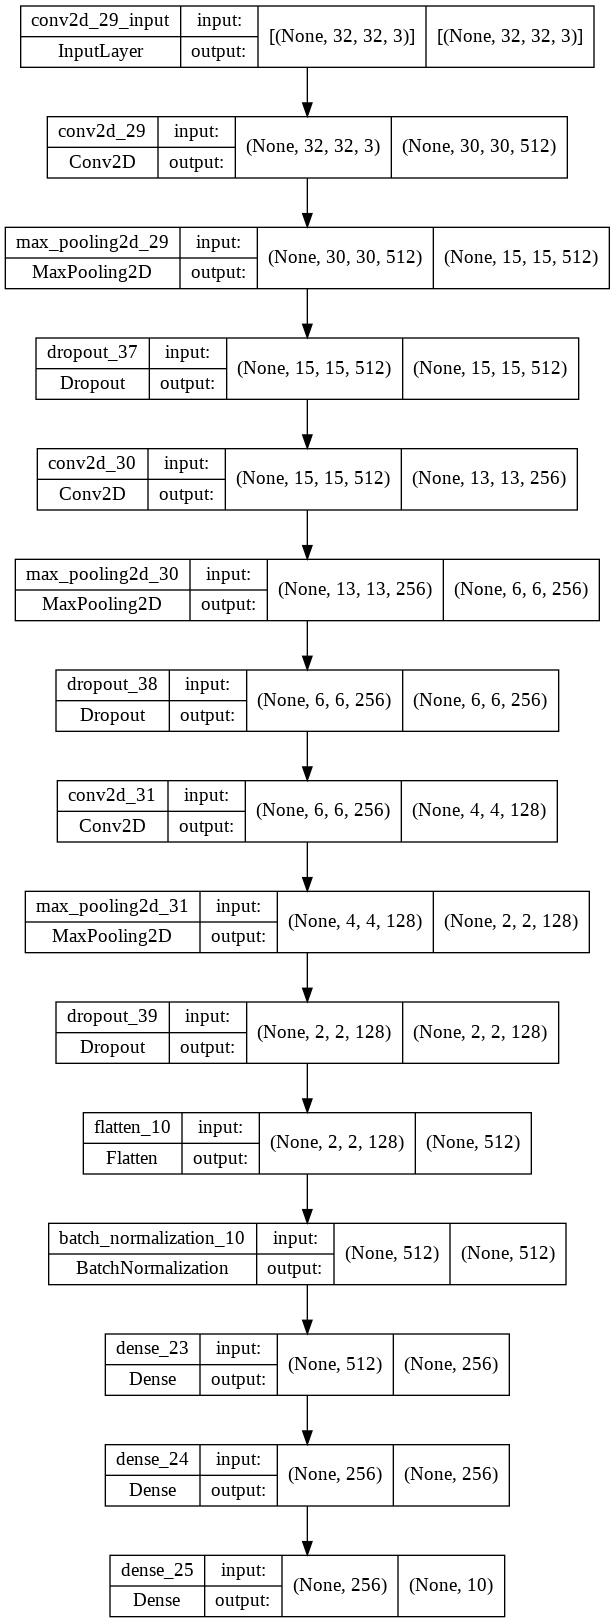

In [106]:
keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

### Compiling the model

In [87]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## Training the model

batch_size = 512 
the default is 64
callbacks to prevent overfitting
saves the model as 

In [90]:
history = model.fit(x_train_norm,
                    y_train_split,
                    epochs=118,
                    batch_size=415,
                    validation_data=(x_valid_norm, y_valid_split),
                    callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])                                                                                               

Epoch 1/118
109/109 [==============================] - 6s 50ms/step - loss: 0.5400 - accuracy: 0.8371 - val_loss: 0.7730 - val_accuracy: 0.7744
Epoch 2/118
109/109 [==============================] - 5s 46ms/step - loss: 0.5191 - accuracy: 0.8437 - val_loss: 0.6730 - val_accuracy: 0.7988
Epoch 3/118
109/109 [==============================] - 5s 46ms/step - loss: 0.5279 - accuracy: 0.8410 - val_loss: 0.6603 - val_accuracy: 0.8022
Epoch 4/118
109/109 [==============================] - 5s 46ms/step - loss: 0.5150 - accuracy: 0.8476 - val_loss: 0.6673 - val_accuracy: 0.8050
Epoch 5/118
109/109 [==============================] - 5s 46ms/step - loss: 0.5102 - accuracy: 0.8478 - val_loss: 0.6435 - val_accuracy: 0.8098
Epoch 6/118
109/109 [==============================] - 5s 46ms/step - loss: 0.5148 - accuracy: 0.8465 - val_loss: 0.7006 - val_accuracy: 0.7884
Epoch 7/118
109/109 [==============================] - 5s 46ms/step - loss: 0.5193 - accuracy: 0.8454 - val_loss: 0.6478 - val_accuracy:

###Evaluate the model on the test dataset 

In [91]:
loss, accuracy = model.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 4ms/step - loss: 0.6744 - accuracy: 0.8098
test set accuracy:  80.98000288009644


### Plotting performance metrics 
* use Matplotlib to create two plots displaying the training and validation loss and training and validation accuracy for each training epoch

In [92]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [93]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
4,0.510,0.848,0.644,0.810
5,0.515,0.847,0.701,0.788
6,0.519,0.845,0.648,0.815
7,0.504,0.849,0.667,0.807
8,0.499,0.852,0.656,0.813


In [94]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

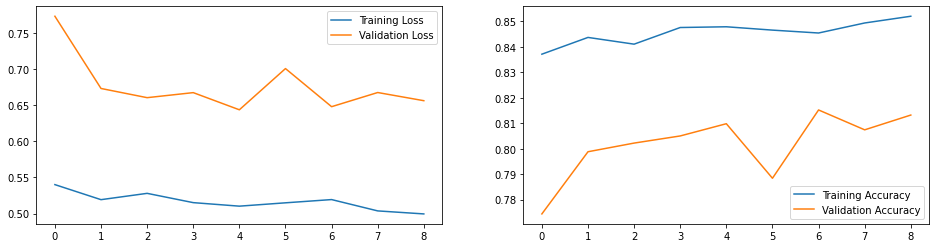

In [95]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion matrix


In [100]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


In [101]:
pred1 = model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

In [103]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1000
           1       0.93      0.90      0.91      1000
           2       0.76      0.70      0.73      1000
           3       0.60      0.70      0.65      1000
           4       0.80      0.80      0.80      1000
           5       0.72      0.74      0.73      1000
           6       0.83      0.88      0.85      1000
           7       0.88      0.80      0.84      1000
           8       0.86      0.92      0.89      1000
           9       0.89      0.88      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

Accuracy Score: 0.8098
Root Mean Square Error: 1.7259200444980063


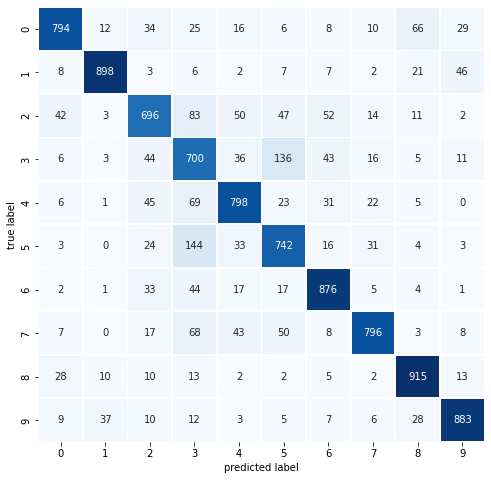

In [104]:
plot_confusion_matrix(y_test,pred1)

### Predictions

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0.64%,0.02%,0.66%,80.64%,0.12%,15.69%,1.09%,0.43%,0.66%,0.06%
1,0.32%,0.17%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,99.50%,0.00%
2,1.69%,0.21%,0.02%,0.02%,0.00%,0.00%,0.00%,0.00%,97.88%,0.18%
3,84.20%,0.01%,0.04%,0.10%,0.03%,0.00%,0.00%,0.00%,15.60%,0.02%
4,0.00%,0.00%,1.17%,0.43%,6.17%,0.01%,92.21%,0.00%,0.00%,0.00%
5,0.00%,0.00%,0.21%,6.30%,0.14%,1.29%,92.06%,0.00%,0.00%,0.00%
6,0.64%,84.00%,0.08%,0.36%,0.00%,0.05%,0.07%,0.65%,0.01%,14.14%
7,0.00%,0.00%,4.83%,0.56%,1.21%,0.01%,93.39%,0.00%,0.00%,0.00%
8,0.00%,0.00%,0.01%,98.65%,0.10%,1.19%,0.03%,0.02%,0.00%,0.00%
9,2.50%,43.85%,0.99%,0.35%,0.17%,0.14%,3.20%,0.00%,7.19%,41.61%
